# Load JSON File

In [121]:
# General imports
import os, json, cmath, math, sys, traceback, copy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import optimize, signal, interpolate, integrate, stats
from matplotlib.ticker import FormatStrFormatter

# Need use to raw string otherwise backslashes in Windows path accidentally cause problems since interpreter may confuse
# them for escape characters
fdir = r"C:\algos\jupyter-notebooks\data\2021-10-21_8nmNb_10nmAu_9nmTe_ptcontact"
jname = "Transport Info.json"
jpath = os.path.join(fdir, jname)

# Load JSON
jref = open(jpath)
measurements = json.load(jref)
jref.close()

# Unpack filenames
file_list = list(filter(lambda x: x != 'general_info', [*measurements]))

# Print out everything in general_info
print('General Info')
print('Description: {0} \n'.format(measurements['general_info']['description']))

for key in filter(lambda x: x != 'description', [*measurements['general_info']]):
    print('{0}: {1} \n'.format(key, measurements['general_info'][key]))

print('-----'*20 + '\n')
    
# List of keys to display
parameter_keys = ['fields', 'temps']

# Print out file names
for i, file in enumerate(file_list):
    print('{0}. {1} \n'.format(i, file))
    print('Description: {0}\n'.format(measurements[file]['description']))
    for key in parameter_keys:
        if key in measurements[file]:
            print(key + ': ' + ', '.join(map(str, measurements[file][key])) + '\n')
    print('-----'*20)


###########################################################
    
# Define helper functions here (TODO: MOVE THESE INTO A CUSTOM MODULE)

def colIndexGetter(cols_perscan, num_scans):
    """
        Returns a function that gets the index of a column from the complete data array
        given the column index within a scan, scan index, and parameter index.
    """
    return lambda col_index, s_index, p_index: p_index*cols_perscan*num_scans + s_index*cols_perscan + col_index

def multiple_gaussian(x, *params):
    """ Multiple Gaussians function

    Args:
        x: Numpy array of x-data to be used in fitting or plotting
        params*: List of fitting parameters in the following order:
        [y-offset, gaussian1 center, gaussian1 amplitude, gaussian1 stdev, gaussian2 center, gaussian2 amplitude, ...]

    Returns:
        Numpy array of Gaussian y-data calculated from input x-data and parameters

    """
    
    y = np.zeros_like(x)
    for i in range(1, len(params), 3):
        ctr = params[i]
        amp = params[i+1]
        wid = params[i+2]
        y = y + amp * np.exp( -0.5*((x - ctr)/wid)**2)
    return y + params[0]

def fermi_derivative(x, *params):
    """ Fermi-Dirac distribution derivative. 
    
    Assumes x-data is in units of milli-volts (or milli-whatever)

    Args:
        x: Numpy array of x-data to be used in fitting or plotting. Assumes data is in units of mV (or milli-whatever)
        params*: List of fitting parameters in the following order:
        [y-offset, linear offset slope, x-offset, amplitude, temperature]

    Returns:
        Numpy array of Fermi-Dirac derivative y-data calculated from input x-data and parameters

    """
    kb_meV = 8.617 * 10**-2 # Boltzmann constant in units of meV instead of eV
    y = params[0] + params[1]*(x - params[2]) + (1/params[4])*params[3]*np.exp((x - params[2]) / (kb_meV * params[4])) / np.square(np.exp((x - params[2]) / (kb_meV * params[4])) + 1)
    return y

General Info
Description: Transport info 

----------------------------------------------------------------------------------------------------

0. 2021-10-21_RvsT_7uA source_0field_4terminal.txt 

Description: 0 field

----------------------------------------------------------------------------------------------------
1. 2021-10-21_R vs H_7.1517uA_10nmAu_9nmTe_300mK_4terminal.txt 

Description: 300mK temperature

----------------------------------------------------------------------------------------------------


# Single File dIdV Waterfall Gradient Plot

Sample seems to have changed again after multiple condensations. Now the gap no longer seems to close near 2.75T. Instead the gap seems to grow wider as the field is increased.
Num Rows = 201
dV: 2.16e-05 
 Num Scans: 7 
 Num Cols: 4


<IPython.core.display.Javascript object>


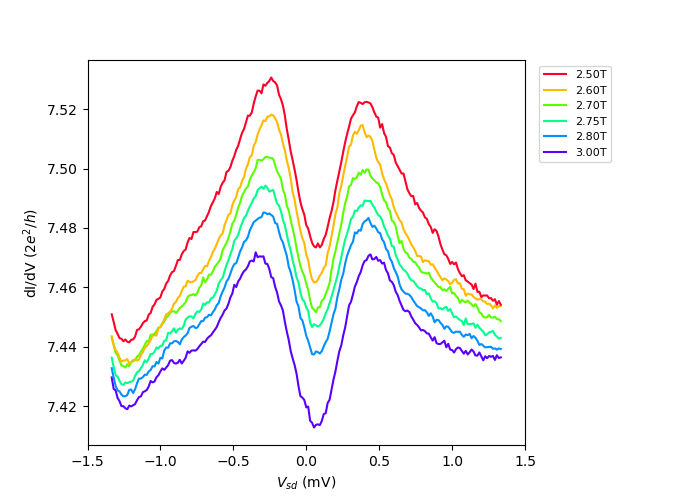

In [44]:
%matplotlib notebook

# Get file path of the corresponding file from the file_list
fname = file_list[8]
fpath = os.path.join(fdir, fname)

# Load data
data = np.genfromtxt(fpath, delimiter="\t", dtype=float)
    
# Get dictionary of measurement information
measure_info = measurements[fname]
num_scans = measure_info['num_scans']
cols_perscan = measure_info['cols_perscan']
dV = measure_info['dV']
params = measure_info['fields']

# Print some info about the file
print(measure_info['description'])
print('Num Rows = {0}'.format(data.shape[0]))
print('dV: {0} \n Num Scans: {1} \n Num Cols: {2}'.format(dV, num_scans, cols_perscan))

# General settings for plotting data
legend_unit = 'T'
xscale = 1000 # Plot in units of mV
yscale =  1 / (dV * 7.7480917*10**-5)
offset = 0
plot_cols = (0, 1) # Pick which cols to plot as x and y
params_to_plot = [7, 8, 9, 10, 11, 12] # Indices of which params to plot

# Choose what to plot: 'average', 'all scans', 'first scan'
plot_type = 'average'

# Calculate average values of a scan if plotting average
avg_x = None
avg_y = None
getColIndex = colIndexGetter(cols_perscan, num_scans)
legend_labels = []

if plot_type == 'average':
    avg_x = list(map(
        lambda a: np.sum([data[:, getColIndex(plot_cols[0], i, a)] for i in range(num_scans)], axis = 0) / num_scans,
        range(len(params))
    ))
    avg_y = list(map(
        lambda a: np.sum([data[:, getColIndex(plot_cols[1], i, a)] for i in range(num_scans)], axis = 0) / num_scans,
        range(len(params))
    ))

# Build colormap so that full range of color map extends across the number of plots to be plotted
plot_cm = plt.cm.gist_rainbow(
    np.linspace(0, 1, len(params_to_plot) + 1 if plot_type != 'all scans' else num_scans*len(params_to_plot) + 1))

# Setup figure
plt.figure(figsize = (7,5))

# Plot the data and build legend
if plot_type == 'average':
    for c, i in enumerate(params_to_plot):
        plt.plot(avg_x[i]*xscale,
                 avg_y[i]*yscale + offset*c,
                 color = plot_cm[c], zorder = 100- 2*c)
        legend_labels.append('{:.2f}{:s}'.format(params[i], legend_unit))

elif plot_type == 'all scans':
    for c, i in enumerate(params_to_plot):
        for n in range(num_scans):
            plt.plot(data[:, getColIndex(plot_cols[0], n, i)]*xscale, 
                     data[:, getColIndex(plot_cols[1], n, i)]*yscale + offset*(c*num_scans + n), 
                     color = plot_cm[c*num_scans + n], zorder = 100 - c - n)
            legend_labels.append('{:.2f}{:s}, Scan {:d}'.format(params[i], legend_unit, n))
else:
    for c, i in enumerate(params_to_plot):
        plt.plot(data[:, getColIndex(plot_cols[0], 0, i)]*xscale,
                 data[:, getcolIndex(plot_cols[1], 0, i)]*yscale + offset*c, 
                 color = plot_cm[c], zorder = 100 - 5*c)
        legend_labels.append('{:.2f}{:s}'.format(params[i], legend_unit))

#plt.plot([-.02, -.02], [9.4, 8], linestyle = '--', color = 'black')

# Adjust ticks and axes limits and labels
#plt.yticks([0, .3])
#plt.yscale('log')
#plt.ylim([8, 9.4])
plt.ylabel(r'dI/dV ($2e^2/h$)')
#plt.ylabel('dI/dV Normalized')

plt.xticks(np.linspace(-1.5, 1.5, num = 7))
plt.xlim([-1.5, 1.5])
plt.xlabel(r'$V_{sd}$ (mV)')

# Adjust subplot position so labels fit inside
plt.gcf().subplots_adjust(right = 0.75)

# Show legend
plt.legend(legend_labels, ncol = 1, prop={'size': 8, 'stretch': 'semi-expanded'},
           bbox_to_anchor = (1.02, 1), loc = 'upper left')

# Show plot
plt.show()

# Save figure
plt.savefig('./plt_img/2022-02-15_EuS_samplechangedagain_2.5T-3T_rainbow.png', transparent = True, dpi = 200)

# Multiple File Average dIdV Waterfall Gradient Plot

<IPython.core.display.Javascript object>


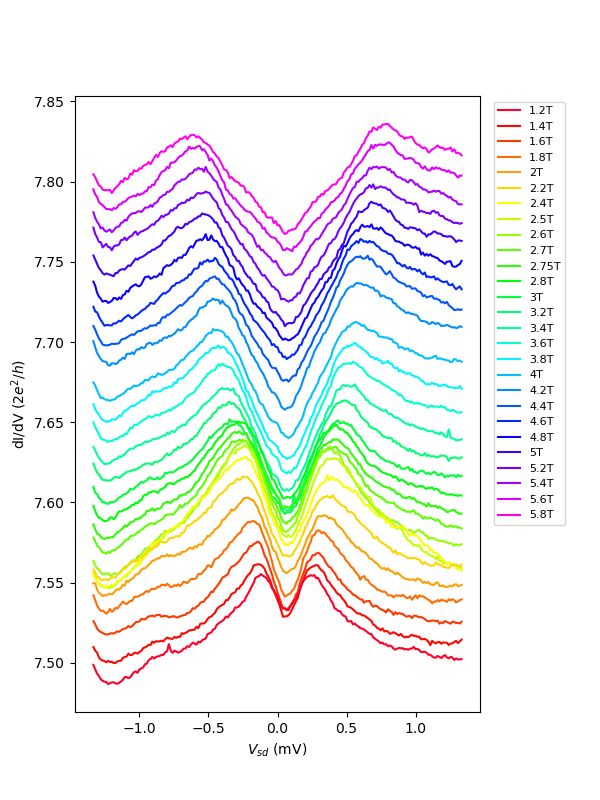

2022-02-15_dIdV_1.2T - 4T_240mK_largerdV_nogapclosing.txt 
 Num Data Sets: 126
 Num Scans: 7 
 Num Cols: 4 
 dV: 2.16e-05 

2022-02-15_dIdV_vary H persistent seq_4.2T - 7T_-1.334mV - 1.334mV_5E-6 dIsens_8.89E-4 Vsdscale_sample1dev3changed_240mK_largerdV.txt 
 Num Data Sets: 90
 Num Scans: 6 
 Num Cols: 4 
 dV: 2.16e-05 

['1.2T', '1.4T', '1.6T', '1.8T', '2T', '2.2T', '2.4T', '2.5T', '2.6T', '2.7T', '2.75T', '2.8T', '3T', '3.2T', '3.4T', '3.6T', '3.8T', '4T', '4.2T', '4.4T', '4.6T', '4.8T', '5T', '5.2T', '5.4T', '5.6T', '5.8T', '6T', '6.2T', '6.4T', '6.6T', '6.8T', '7T']


In [29]:
%matplotlib notebook

# Get list of files from file_list
plot_files = [8, 23]

# General parameters for plotting data
xscale = 1000 # plot in units of mV
offset = 0.015
plot_cols = (0, 1)
legend_unit = 'T'

# Setup figure
plt.figure(figsize = (6,8))

legend_labels = []
avg_xs = []
avg_ys = []

# Get data for each file
for i in plot_files:
    # Load data
    fname = file_list[i]
    fpath = os.path.join(fdir, fname)
    data = np.genfromtxt(fpath, delimiter="\t", dtype=float)
    
    # Get measurement info
    measure_info = measurements[fname]
    num_scans = measure_info['num_scans']
    cols_perscan = 4 #measure_info['cols_perscan']
    dV = measure_info['dV']
    params = measure_info['fields']
    norm = 1 / (dV * 7.7480917*10**-5)
    
    # Print some info about the file
    print('{0} \n Num Data Sets: {1}'.format(fname, int(data.shape[1] / cols_perscan)))
    print(' Num Scans: {0} \n Num Cols: {1} \n dV: {2} \n'.format(num_scans, cols_perscan, dV))
    
    # Calculate average dIdV
    getColIndex = colIndexGetter(cols_perscan, num_scans)
    
    avg_xs.extend(map(
        lambda a: xscale*np.sum([data[:, getColIndex(plot_cols[0], i, a)] for i in range(num_scans)], axis = 0) / num_scans,
        range(len(params))
    ))
    
    avg_ys.extend(map(
        lambda a: norm*np.sum([data[:, getColIndex(plot_cols[1], i, a)] for i in range(num_scans)], axis = 0) / num_scans,
        range(len(params))
    ))
    
    # Add labels for the legend
    legend_labels.extend(['{0}{1}'.format(p, legend_unit) for p in params])
    

# Print list of parameters
print(legend_labels)

# Pick parameters to plot
params_to_plot = range(len(legend_labels) - 6)

# Build colormap
plot_cm = plt.cm.gist_rainbow(np.linspace(0, 1, len(params_to_plot) + 1))

# Plot the data
for a, index in enumerate(params_to_plot):
    plt.plot(avg_xs[index], avg_ys[index] + offset*a, color = plot_cm[a], zorder = 100 - 2*a)

#for i, avg_x in enumerate(avg_xs):
#    plt.plot(avg_x*xscale, avg_ys[i]*norm + offset*i, color = plot_cm[i], zorder = 100- 2*i)

# Adjust ticks and axes limits and labels
#plt.yticks([0, .3])
#plt.yscale('log')
#plt.ylim([8, 9.4])
plt.ylabel(r'dI/dV ($2e^2/h$)')
#plt.ylabel('dI/dV Normalized')

#plt.xticks([-.5, -.25, 0, .25, .5])
#plt.xlim([-.5, .5])
plt.xlabel(r'$V_{sd}$ (mV)')

# Adjust subplot position so labels fit inside
plt.gcf().subplots_adjust(right = 0.8)

# Build legend
plt.legend(legend_labels, ncol = 1, prop={'size': 8, 'stretch': 'semi-expanded'},
           bbox_to_anchor = (1.02, 1), loc = 'upper left')

# Show plot
plt.show()

# Save figure
plt.savefig('./plt_img/2022-02-15_EuS_dIdV_1.2T - 5.8T_234mK_rawdata.png', transparent = True, dpi = 200)

# Single file Average dI/dV Heat / Intensity Map Plotting

Sample changed higher resistance. X offset corrected. File is combination of two files: 2022-02-15_dIdV_vary H seq_2.6T - 2.9T_-1.334mV - 1.334mV_201 steps_5E-6 dIsens_8.89E-4 Vsdscale_sample1dev3changed_240mK.txt and 2022-02-15_dIdV_vary H persis uniform_1.00T - 4.00T_-1.334mV - 1.334mV_201 steps_5E-6 dIsens_8.89E-4 Vsdscale_sample1dev3changed_240mK.txt
Num Rows = 201, Num Cols = 38
dV: 1.44e-05 
Num Scans: 1 
Num Cols: 2
Fields:
[1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.6, 2.65, 2.7, 2.75, 2.8, 2.85, 2.9, 3, 3.25, 3.5, 3.75, 4]


<IPython.core.display.Javascript object>


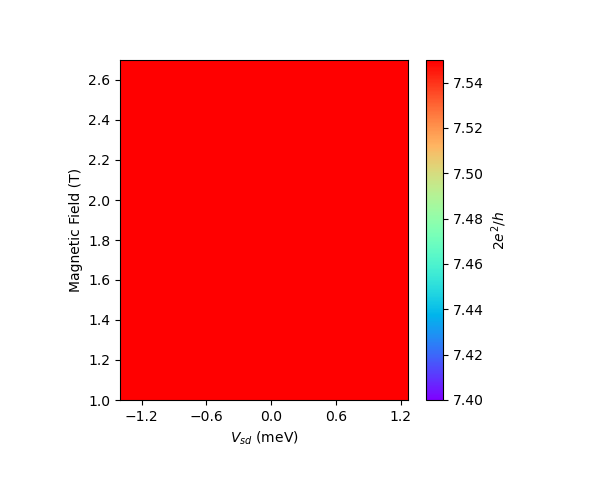

In [4]:
%matplotlib notebook

# Get file path of the corresponding file from the file_list
fname = file_list[28]
fpath = os.path.join(fdir, fname)
#fpath = os.path.join(r'C:\algos\jupyter-notebooks\data\2021-02-17_8nm Nb_15nm Au_7nm Te_pt contact\3rd contact',
#                     '2021-02-17_3rdptcontact_dIdV_300mK_0T-2.4T inplane_15nm Au_7nm Te_unnormalized_25uVdV.txt')

# Load data
data = np.genfromtxt(fpath, delimiter="\t", dtype=float)

# Get measurement info
measure_info = measurements[fname]
num_scans = measure_info['num_scans']
cols_perscan = measure_info['cols_perscan']
dV = measure_info['dV']
params = measure_info['fields']

print(measure_info['description'])
print('Num Rows = {0}, Num Cols = {1}'.format(data.shape[0], data.shape[1]))
print('dV: {0} \nNum Scans: {1} \nNum Cols: {2}'.format(dV, num_scans, cols_perscan))
print('Fields:')
print(params)

# General parameters for plotting data
xlimits = (-.0015, .0015) # Since individual plots may be offset along x-axis from each other, find a common x-interval to use for heat map
xscale = 1000 # plot in units of mV
zscale = 1 / (dV * 7.7480917*10**-5)
plot_cols = (0, 1) # Cols to use as x and z
p_int = (0, 10) # Pick an continuous interval of plots to use to form the heatmap
zmin = 7.4
zmax = 7.55

# Calculate averages
getColIndex = colIndexGetter(cols_perscan, num_scans)

avg_x = list(map(
    lambda a: np.sum([data[:, getColIndex(plot_cols[0], i, a)] for i in range(num_scans)], axis = 0) / num_scans,
    range(p_int[0], p_int[1])
))

avg_z = list(map(
    lambda a: np.sum([data[:, getColIndex(plot_cols[1], i, a)] for i in range(num_scans)], axis = 0) / num_scans,
    range(p_int[0], p_int[1])
))

# Form the mesh arrays for the heatmap
x = []
z = []

for i in range(len(avg_x)):
    x.append(avg_x[i][np.nonzero(np.logical_and(avg_x[i] >= xlimits[0], avg_x[i] <= xlimits[1]))])
    z.append(avg_z[i][np.nonzero(np.logical_and(avg_x[i] >= xlimits[0], avg_x[i] <= xlimits[1]))])
    
# Reshape arrays
for i in range(len(avg_x)):
    x[i] = np.reshape(x[i], (1, len(x[i])))
    z[i] = np.reshape(z[i], (1, len(z[i])))
    

z = zscale * np.concatenate(z, axis = 0)
x = xscale * np.concatenate(x, axis = 0)

# Repeat params array and then reshape to get the Y-coord grid, similar to what one would get from meshgrid
y = np.repeat(params[p_int[0]:p_int[1]], x.shape[1], axis = 0)
y = np.reshape(y, (p_int[1] - p_int[0], x.shape[1]))

# Plot data
fig, ax = plt.subplots(figsize = (6, 5))
pmesh = ax.pcolormesh(x, y, z, vmin = zmin, vmax = zmax, shading = 'gouraud', cmap = plt.get_cmap('rainbow'))

# Setup colorbar
cbar = plt.colorbar(pmesh, orientation = 'vertical')
cbar.set_label(r'$2e^2/h$')

# Adjust x,y axis ticks and labels        
ax.set_xlabel(r'$V_{sd}$ (meV)')
ax.set_ylabel('Magnetic Field (T)')
ax.set_xticks(np.linspace(-1.2, 1.2, num = 5))
#ax.set_xlim([-.5, .5])
#ax.set_yticks(np.linspace(0, 4, num = 17))

# Adjust plot so labels are visible
plt.subplots_adjust(left = 0.2 ,bottom = 0.2, right = 0.8)

plt.show()

#plt.savefig('./plt_img/2022-02-15_EuS_samplechangedagain_1.2T-4T.png', transparent = True)

# Multiple file average dIdV heat map plotting

<IPython.core.display.Javascript object>


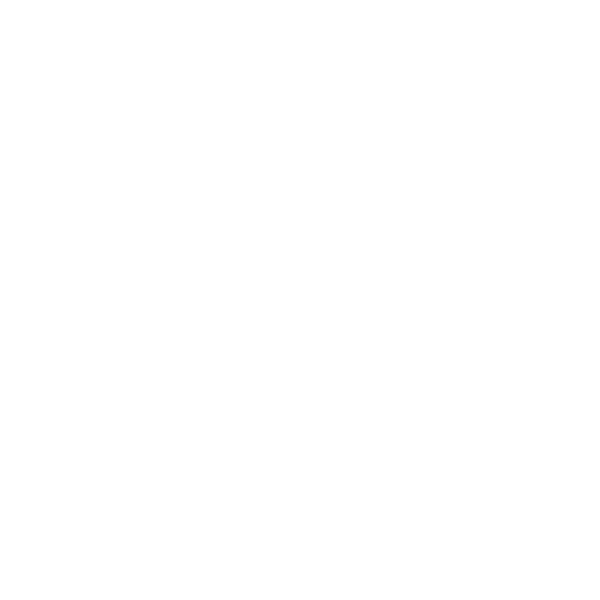

2022-02-15_dIdV_1.2T - 4T_240mK_largerdV_nogapclosing.txt 
 Num Data Sets: 126
 Num Scans: 7 
 Num Cols: 4 
 dV: 2.16e-05 

2022-02-15_dIdV_vary H persistent seq_4.2T - 7T_-1.334mV - 1.334mV_5E-6 dIsens_8.89E-4 Vsdscale_sample1dev3changed_240mK_largerdV.txt 
 Num Data Sets: 90
 Num Scans: 6 
 Num Cols: 4 
 dV: 2.16e-05 

Total num parameters: 33
[1.2, 1.4, 1.6, 1.8, 2, 2.2, 2.4, 2.5, 2.6, 2.7, 2.75, 2.8, 3, 3.2, 3.4, 3.6, 3.8, 4, 4.2, 4.4, 4.6, 4.8, 5, 5.2, 5.4, 5.6, 5.8, 6, 6.2, 6.4, 6.6, 6.8, 7]


<IPython.core.display.Javascript object>


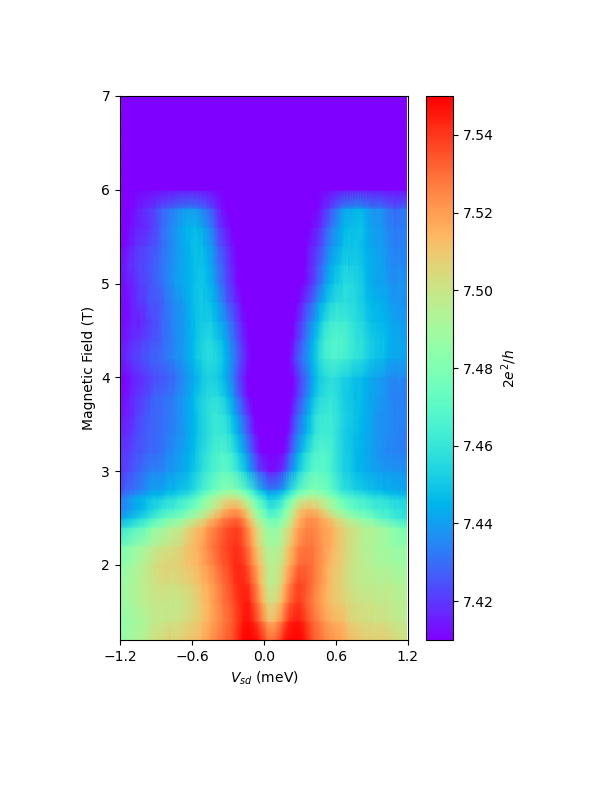

In [17]:
%matplotlib notebook

# Get list of files from file_list
plot_files = [8, 23]

# General parameters for plotting data
xlimits = (-.0012, .0012) # Since individual plots may be offset along x-axis from each other, find a common x-interval to use for heat map
xscale = 1000 # plot in units of mV
plot_cols = (0, 1) # Cols to use as x and z
zmin = 7.41
zmax = 7.55

# Setup figure
plt.figure(figsize = (6,6))

avg_xs = []
avg_zs = []
total_params = []

# Get data for each file
for i in plot_files:
    # Load data
    fname = file_list[i]
    fpath = os.path.join(fdir, fname)
    data = np.genfromtxt(fpath, delimiter="\t", dtype=float)
    
    # Get measurement info
    measure_info = measurements[fname]
    num_scans = measure_info['num_scans']
    cols_perscan = measure_info['cols_perscan']
    dV = measure_info['dV']
    params = measure_info['fields']
    zscale = 1 / (dV * 7.7480917*10**-5)
    
    # Print some info about the file
    print('{0} \n Num Data Sets: {1}'.format(fname, int(data.shape[1] / cols_perscan)))
    print(' Num Scans: {0} \n Num Cols: {1} \n dV: {2} \n'.format(num_scans, cols_perscan, dV))
    
    # Calculate average dIdV
    getColIndex = colIndexGetter(cols_perscan, num_scans)
    
    avg_xs.extend(list(map(
        lambda a: xscale*np.sum([data[:, getColIndex(plot_cols[0], i, a)] for i in range(num_scans)], axis = 0) / num_scans,
        range(len(params))
    )))
    
    avg_zs.extend(list(map(
        lambda a: zscale*np.sum([data[:, getColIndex(plot_cols[1], i, a)] for i in range(num_scans)], axis = 0) / num_scans,
        range(len(params))
    )))
    
    # Extend complete list of params
    total_params.extend(params)


print('Total num parameters: {0}'.format(len(total_params)))
print(total_params)
p_int = (0, len(total_params)) # Pick an continuous interval of plots to use to form the heatmap

# Form the mesh arrays for the heatmap
x = []
z = []

for i in range(len(avg_xs)):
    x.append(avg_xs[i][np.nonzero(np.logical_and(avg_xs[i] >= xscale*xlimits[0], avg_xs[i] <= xscale*xlimits[1]))])
    z.append(avg_zs[i][np.nonzero(np.logical_and(avg_xs[i] >= xscale*xlimits[0], avg_xs[i] <= xscale*xlimits[1]))])
    
# Reshape arrays into 2D arrays for concatenation
for i in range(len(avg_xs)):
    x[i] = np.reshape(x[i], (1, len(x[i])))
    z[i] = np.reshape(z[i], (1, len(z[i])))

z = np.concatenate(z, axis = 0)
x = np.concatenate(x, axis = 0)

# Repeat params array and then reshape to get the Y-coord grid, similar to what one would get from meshgrid
y = np.repeat(total_params, x.shape[1], axis = 0)
y = np.reshape(y, (len(total_params), x.shape[1]))

# Plot data
fig, ax = plt.subplots(figsize = (6, 8))
pmesh = ax.pcolormesh(x[p_int[0]:p_int[1], :],
                      y[p_int[0]:p_int[1], :], 
                      z[p_int[0]:p_int[1], :],
                      vmin = zmin, vmax = zmax, shading = 'gouraud', cmap = plt.get_cmap('rainbow'))

# Setup colorbar
cbar = plt.colorbar(pmesh, orientation = 'vertical')
cbar.set_label(r'$2e^2/h$')

# Adjust x,y axis ticks and labels        
ax.set_xlabel(r'$V_{sd}$ (meV)')
ax.set_ylabel('Magnetic Field (T)')
ax.set_xticks(np.linspace(-1.2, 1.2, num = 5))
#ax.set_xlim([-.5, .5])
#ax.set_yticks(np.linspace(0, 4, num = 17))

# Adjust plot so labels are visible
plt.subplots_adjust(left = 0.2 ,bottom = 0.2, right = 0.8)

plt.show()

plt.savefig('./plt_img/2022-02-15_EuS_dIdV_1.2T-7T_240mK_heatmap.png', transparent = True, dpi = 200)

# Grid of Small Plots

In [ ]:
%matplotlib notebook

# Get list of files from file_list
plot_files = [6]

# General parameters for plotting data
xscale = 1000 # plot in units of mV
offset = 0
plot_cols = (0, 1)
legend_unit = 'T'

# Setup figure
plt.figure(figsize = (6,8))

legend_labels = []
avg_xs = []
avg_ys = []

# Get data for each file
for i in plot_files:
    # Load data
    fname = file_list[i]
    fpath = os.path.join(fdir, fname)
    data = np.genfromtxt(fpath, delimiter="\t", dtype=float)
    
    # Get measurement info
    measure_info = measurements[fname]
    num_scans = measure_info['num_scans']
    cols_perscan = 4 #measure_info['cols_perscan']
    dV = measure_info['dV']
    params = measure_info['fields']
    norm = 1 / (dV * 7.7480917*10**-5)
    
    # Print some info about the file
    print('{0} \n Num Data Sets: {1}'.format(fname, int(data.shape[1] / cols_perscan)))
    print(' Num Scans: {0} \n Num Cols: {1} \n dV: {2} \n'.format(num_scans, cols_perscan, dV))
    
    # Calculate average dIdV
    getColIndex = colIndexGetter(cols_perscan, num_scans)
    
    avg_xs.extend(map(
        lambda a: xscale*np.sum([data[:, getColIndex(plot_cols[0], i, a)] for i in range(num_scans)], axis = 0) / num_scans,
        range(len(params))
    ))
    
    avg_ys.extend(map(
        lambda a: norm*np.sum([data[:, getColIndex(plot_cols[1], i, a)] for i in range(num_scans)], axis = 0) / num_scans,
        range(len(params))
    ))
    
    # Add labels for the legend
    legend_labels.extend(['{0}{1}'.format(p, legend_unit) for p in params])
    

# Print list of parameters
print(legend_labels)

# Pick parameters to plot. Also setup the grid arrangement and size of each plot. 
params_to_plot = [2,3,4,5]
grid = (2, 2) # Grid dimensions. Example: (2,3) = 2 rows, 3 cols
plot_size = (3, 2) # Width and height of each plot

# Build color map for plots (in case you want different colored plots)
plot_cm = plt.cm.gist_rainbow(np.linspace(0, 1, len(params_to_plot) + 1))


# Setup subplots
fig, ax = plt.subplots(nrows = grid[0], ncols = grid[1], figsize = (plot_size[0]*grid[0], plot_size[1]*grid[1]))

# Plot the data
for r_index in range(grid[0]):
    for c_index in range(grid[1]):
        i = r_index*grid[0] + c_index
        ax[r_index, c_index].plot(avg_xs[params_to_plot[i]], avg_ys[params_to_plot[i]], color = plot_cm[i])
        
        # Adjust tick size
        ax[r_index, c_index].tick_params(axis = 'both', labelsize = 'small')
        
        # Adjust tick number
        ax[r_index, c_index].locator_params(axis = 'x', nbins = 5)
        ax[r_index, c_index].locator_params(axis = 'y', nbins = 5)
        
        # Add label to plot
        ax[r_index, c_index].text(x = .8, y = .85, s = legend_labels[params_to_plot[i]], fontsize = 10,
                                  transform = ax[r_index, c_index].transAxes)

# Adjust plot so that labels aren't cut off
plt.subplots_adjust(bottom = 0.2)

# Add labels for x and y axis
fig.text(0, 0.51, r'dI/dV $(2e^2/h)$', va='center', rotation='vertical', fontsize = 14)
fig.text(0.45, 0.1, r'$V_{sd}$ (mV)', va='center', rotation='horizontal', fontsize = 14)
#plt.xlabel(r'$V_{sd}$ (mV)')

# Show the plot
plt.show()

# Save the figure
#plt.savefig('./plt_img/dIdV_ptcontact_barrier comparison.png', dpi = 200, transparent = True)

# Stacked Grid of Plots with Shared X-Axis

In [ ]:
%matplotlib notebook

# Get list of files from file_list
plot_files = [6]

# General parameters for plotting data
xscale = 1000 # plot in units of mV
offset = 0
plot_cols = (0, 1)
legend_unit = 'T'

# Setup figure
plt.figure(figsize = (6,8))

legend_labels = []
avg_xs = []
avg_ys = []

# Get data for each file
for i in plot_files:
    # Load data
    fname = file_list[i]
    fpath = os.path.join(fdir, fname)
    data = np.genfromtxt(fpath, delimiter="\t", dtype=float)
    
    # Get measurement info
    measure_info = measurements[fname]
    num_scans = measure_info['num_scans']
    cols_perscan = 4 #measure_info['cols_perscan']
    dV = measure_info['dV']
    params = measure_info['fields']
    norm = 1 / (dV * 7.7480917*10**-5)
    
    # Print some info about the file
    print('{0} \n Num Data Sets: {1}'.format(fname, int(data.shape[1] / cols_perscan)))
    print(' Num Scans: {0} \n Num Cols: {1} \n dV: {2} \n'.format(num_scans, cols_perscan, dV))
    
    # Calculate average dIdV
    getColIndex = colIndexGetter(cols_perscan, num_scans)
    
    avg_xs.extend(map(
        lambda a: xscale*np.sum([data[:, getColIndex(plot_cols[0], i, a)] for i in range(num_scans)], axis = 0) / num_scans,
        range(len(params))
    ))
    
    avg_ys.extend(map(
        lambda a: norm*np.sum([data[:, getColIndex(plot_cols[1], i, a)] for i in range(num_scans)], axis = 0) / num_scans,
        range(len(params))
    ))
    
    # Add labels for the legend
    legend_labels.extend(['{0}{1}'.format(p, legend_unit) for p in params])
    

# Print list of parameters
print(legend_labels)

# Pick parameters to plot. Also setup the grid arrangement and size of each plot. 
params_to_plot = range(3)
plot_size = (5, 2) # Width and height of each plot

# Build color map for plots (in case you want different colored plots)
plot_cm = plt.cm.gist_rainbow(np.linspace(0, 1, len(params_to_plot) + 1))


# Setup subplots
fig, ax = plt.subplots(nrows = len(params_to_plot), ncols = 1, 
                       figsize = (plot_size[0], plot_size[1]*len(params_to_plot)), sharex = True)

# Plot the data
for i, index in enumerate(params_to_plot):
    ax[i].plot(avg_xs[index], avg_ys[index], color = plot_cm[i])
    
    # Adjust tick size
    ax[i].tick_params(axis = 'both', labelsize = 'small')

    # Adjust tick number and locations
    #ax[i].locator_params(axis = 'x', nbins = 5)
    ax[i].set_xticks(np.linspace(-1.5, 1.5, num = 7))
    ax[i].locator_params(axis = 'y', nbins = 5)

    # Add label to plot
    ax[i].text(x = .8, y = .85, s = legend_labels[index], fontsize = 10,
                              transform = ax[i].transAxes)

# Adjust plot so that labels aren't cut off
plt.subplots_adjust(hspace = 0, left = 0.2, bottom = 0.2)

# Add labels for x and y axis
fig.text(0, 0.51, r'dI/dV $(2e^2/h)$', va='center', rotation='vertical', fontsize = 14)
fig.text(0.45, 0.15, r'$V_{sd}$ (mV)', va='center', rotation='horizontal', fontsize = 14)
#plt.xlabel(r'$V_{sd}$ (mV)')

# Show the plot
plt.show()

# Save the figure
#plt.savefig('./plt_img/dIdV_ptcontact_barrier comparison.png', dpi = 200, transparent = True)

# Curve Fitting

Num data pts = 201, Num Plots = 10
Parameter sliced = 0.096


<IPython.core.display.Javascript object>


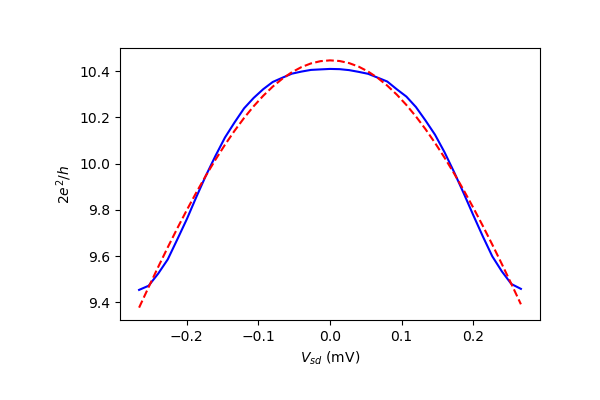

dV
0.00017316
Fitting parameters
[5.78645315e+00 2.71184766e-02 5.55319248e+01 2.97918040e+00]


In [53]:
%matplotlib notebook

# Get list of files from file_list
plot_files = [6]

# General parameters for plotting data
xscale = 1000 # plot in units of mV
offset = 0
plot_cols = (0, 1)
legend_unit = 'T'

# Setup figure
plt.figure(figsize = (6,8))

legend_labels = []
avg_xs = []
avg_ys = []

# Get data for each file
for i in plot_files:
    # Load data
    fname = file_list[i]
    fpath = os.path.join(fdir, fname)
    data = np.genfromtxt(fpath, delimiter="\t", dtype=float)
    
    # Get measurement info
    measure_info = measurements[fname]
    num_scans = measure_info['num_scans']
    cols_perscan = 4 #measure_info['cols_perscan']
    dV = measure_info['dV']
    params = measure_info['fields']
    norm = 1 / (dV * 7.7480917*10**-5)
    
    # Print some info about the file
    print('{0} \n Num Data Sets: {1}'.format(fname, int(data.shape[1] / cols_perscan)))
    print(' Num Scans: {0} \n Num Cols: {1} \n dV: {2} \n'.format(num_scans, cols_perscan, dV))
    
    # Calculate average dIdV
    getColIndex = colIndexGetter(cols_perscan, num_scans)
    
    avg_xs.extend(map(
        lambda a: xscale*np.sum([data[:, getColIndex(plot_cols[0], i, a)] for i in range(num_scans)], axis = 0) / num_scans,
        range(len(params))
    ))
    
    avg_ys.extend(map(
        lambda a: norm*np.sum([data[:, getColIndex(plot_cols[1], i, a)] for i in range(num_scans)], axis = 0) / num_scans,
        range(len(params))
    ))
    
    # Add labels for the legend
    legend_labels.extend(['{0}{1}'.format(p, legend_unit) for p in params])

    
# Pick a plot for fitting
plot_index = 0
x_window = [92, 118] # Specify the region of x-data you want the fitting to happens
print('Parameter picked = {}'.format(legend_labels[plot_index]))

# Fit the curve to the appropriate function
parameter_guess = [8, 0, .15, 5, .24]
curve_fit, pcov = optimize.curve_fit(fermi_derivative, avg_xs[plot_index][x_window[0] : x_window[1]],
                                     avg_ys[plot_index][x_window[0] : x_window[1]], parameter_guess)

# Display fitting parameters
print('Fitting parameters:')
print(curve_fit)

# Setup the plot
fig, ax = plt.subplots(figsize = (6, 4))

# Plot the original data
ax.plot(avg_xs[plot_index][x_window[0] : x_window[1]],
        avg_ys[plot_index][x_window[0] : x_window[1]], color = 'blue')

# Calculate the fitted curve and plot it
fitted_y = fermi_derivative(avg_xs[plot_index][x_window[0] : x_window[1]], *curve_fit)
ax.plot(avg_xs[plot_index][x_window[0] : x_window[1]], fitted_y, color = 'red', linestyle = '--')

# Label the axes
ax.set_ylabel(r'$2e^2/h$')
ax.set_xlabel(r'$V_{sd}$ (mV)')

# Adjust plot so labels are visible
plt.subplots_adjust(bottom = 0.2)

# Adjust ticks

# Show plot
plt.show()

# Save figure
#plt.savefig('./plt_img/2022-02-15_EuS_dIdV_1.2T-7T_240mK_heatmap.png', transparent = True, dpi = 200)

# Superconducting Tc Estimation - Linear extrapolation of transition

Tc = 4.841421865835901


<IPython.core.display.Javascript object>


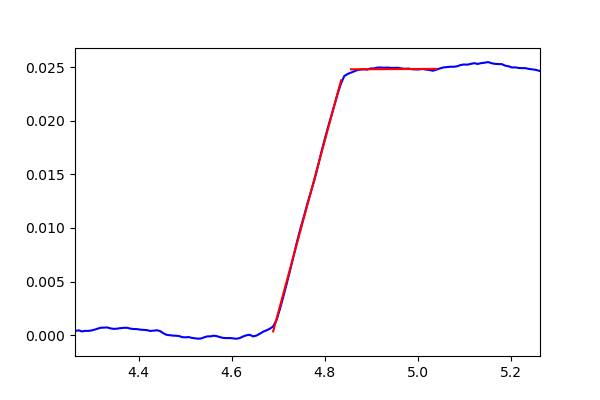

In [157]:
%matplotlib notebook

# Get file path of the corresponding file from the file_list
fname = file_list[0]
fpath = os.path.join(fdir, fname)

# Load data
data = np.genfromtxt(fpath, delimiter="\t", dtype=float)
rv = data[:, 1]
t = data[:, 0]

# Arrange data so that temperature is monotonic increasing
if t[0] > t[1]:
    t = np.flip(t)
    rv = np.flip(rv)

# Get dictionary of measurement information
measure_info = measurements[fname]
num_scans = measure_info['num_scans']
cols_perscan = measure_info['cols_perscan']

# Low-pass filter the data if necessary to remove any noise

# Estimate drop point via first derivative
drdt = np.gradient(rv, t)

# Find the first derivative peak that corresponds to the transition drop using a Ricker wavelet transform
avg_stepsize = abs(t[-1] - t[0])/len(t)

widths = np.linspace(.01 / avg_stepsize, .5 / avg_stepsize, num = 20)
max_distances = widths / 4

peak_indices = signal.find_peaks_cwt(drdt, widths = widths, max_distances = max_distances, 
                                    min_length = int(len(widths) / 3), min_snr = 1,
                                    wavelet = signal.ricker)


# Ideallly the transition should result in the largest peak in the derivative signal
drop_index = np.take(peak_indices, np.argmax(np.take(drdt, peak_indices)))
drop_pos = t[drop_index]

# Fit the curve to a Gaussian to estimate the width of the peak and therefore the size of the window
# in which the drop occurs
gauss_fit, pcov = optimize.curve_fit(multiple_gaussian, t, drdt, [0, drop_pos, 1, .5])
stdev = abs(gauss_fit[3])

# Estimate the window over which the drop occurs
drop_window = np.nonzero(np.logical_and(t >= drop_pos - stdev, t <= drop_pos + stdev))
drop_t = t[drop_window]
drop_rv = rv[drop_window]

# Fit the drop section to a linear curve
drop_fit = stats.linregress(drop_t, drop_rv)

# Pick the a section of the plateau before the drop
plateau_window = np.nonzero(np.logical_and(t >= drop_pos + stdev + 0.01, t <= drop_pos + stdev +  0.2))
plateau_t = t[plateau_window]
plateau_rv = rv[plateau_window]
plateau_fit = stats.linregress(plateau_t, plateau_rv)

# Print out the estimated Tc
print('Tc = {0}'.format((drop_fit.intercept - plateau_fit.intercept) / (plateau_fit.slope - drop_fit.slope)))

# Setup the plot
fig, ax = plt.subplots(figsize = (6, 4))

# Plot the data with the fitted lines
ax.plot(t, rv, color = 'blue')
#ax.plot(t,drdt, color = 'blue')
ax.plot(drop_t, drop_fit.slope * drop_t + drop_fit.intercept, color = 'red')
ax.plot(plateau_t, plateau_fit.slope * plateau_t + plateau_fit.intercept, color = 'red')
ax.set_xlim((drop_pos - .5, drop_pos + .5))

# Display plot and save
plt.show()

# Combine Files

In [3]:
# List of indices of files to combine
combine_files = [13, 21]

# List out parameters for each file
for index in combine_files:
    fname = file_list[index]
    print('\n{0}. {1}'.format(index, fname))
    print(measurements[fname]['fields'])


13. 2022-02-15_dIdV_vary H persistent seq_1.2T - 2.6T_-1.334mV - 1.334mV_5E-6 dIsens_8.89E-4 Vsdscale_sample1dev3changed_240mK_largerdV.txt
[1.2, 1.4, 1.6, 1.8, 2, 2.2, 2.4, 2.5, 2.6]

21. 2022-02-15_dIdV_vary H persistent seq_2.7T - 4T_-1.334mV - 1.334mV_5E-6 dIsens_8.89E-4 Vsdscale_sample1dev3changed_240mK_largerdV_2ndrun.txt
[2.7, 2.75, 2.8, 3, 3.2, 3.4, 3.6, 3.8, 4]


In [7]:
# Pick order of parameters to combine from each file
# Structure as a list of 2-element tuples: (file_index, parameter_index)

new_order = [(13, 0), (13, 1), (13, 2), (13, 3), (13, 4), (13, 5), (13, 6), (13, 7), (13, 8), 
            (21, 0), (21, 1), (21, 2), (21, 3), (21, 4), (21, 5), (21, 6), (21, 7), (21, 8)]

# Load data
file_mapper = dict(zip(combine_files, [i for i in range(len(combine_files))]))
data_list = []

for index in combine_files:
    fname = file_list[index]
    fpath = os.path.join(fdir, fname)
    data_list.append(np.genfromtxt(fpath, delimiter="\t", dtype=float))
    

# Combine data
plot_list = []    
for pair in new_order:
    
    file_index = pair[0]
    parameter_index = pair[1]
    
    # Get measurement info
    measure_info = measurements[file_list[file_index]]
    cols_perscan = measure_info['cols_perscan']
    num_scans = measure_info['num_scans']
    
    # Get data from data_list
    data = data_list[file_mapper[file_index]]
    
    # Append data at specific parameter to list
    start = cols_perscan*num_scans*parameter_index
    plot_list.append(data[:, start : start + cols_perscan*num_scans])
    

# Save file
np.savetxt(r'./data/2022-02-15_EuS/2022-02-15_dIdV_1.2T - 4T_240mK_largerdV_nogapclosing.txt',
           np.hstack(plot_list), fmt = '%.5e', delimiter = '\t')


In [ ]:
# Create a new dictionary to update JSON file

# Since we usually combine files with similar measurement settings, use an existing dict as a base
new_info = copy.deepcopy(measurements[file_list[combine_files[0]]])
new_info['fields'] = [measurements[file_list[p[0]]]['fields'][p[1]] for p in new_order]
new_info['description'] = 'Sample seems to have changed again after multiple condensations. Now the gap no longer seems to close near 2.75T. Instead the gap seems to grow wider as the field is increased.'

new_measurements = {}

with open(jpath, 'r') as jref: 
    new_measurements = json.load(jref)
    new_measurements[filename] = new_info

with open(jpath, 'w') as jref: # open in write mode this time
    json.dump(new_measurements, jref, indent = 4)

# Testing RRR stuff

<IPython.core.display.Javascript object>


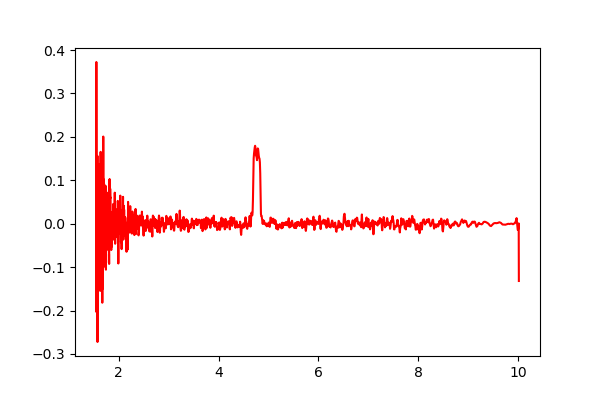

In [98]:
%matplotlib notebook

# Get file path of the corresponding file from the file_list
fname = file_list[0]
fpath = os.path.join(fdir, fname)

# Load data
data = np.genfromtxt(fpath, delimiter="\t", dtype=float)
rv = data[:, 1]
t = data[:, 0]

# Arrange data so that temperature is monotonic increasing
if t[0] > t[1]:
    t = np.flip(t)
    rv = np.flip(rv)

# Get dictionary of measurement information
measure_info = measurements[fname]
num_scans = measure_info['num_scans']
cols_perscan = measure_info['cols_perscan']

# Low-pass filter the data if necessary to remove any noise

# Estimate drop point via first derivative
drdt = np.gradient(rv, t)

fig, ax = plt.subplots(figsize = (6,4))

ax.plot(t, drdt, color = 'red')

plt.show()


[4.765493]


<IPython.core.display.Javascript object>


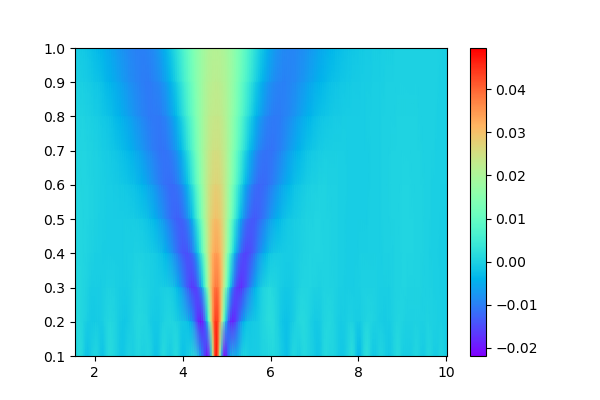

In [115]:
result = ricker_peak_finder(t, drdt, 
                            widths = np.linspace(1, .1, num = 10), 
                            centers = np.linspace(t[0], t[-1], num = 201), 
                            maxima_thresh = np.repeat(.01, 10), 
                            ridge_thresh = .02, 
                            total_thresh = .02)

print(result['locations'])

fig, ax = plt.subplots(figsize = (6, 4))
pmesh = ax.pcolormesh(result['c_mesh'],
                      result['w_mesh'], 
                      result['transform'],
                      shading = 'gouraud', cmap = plt.get_cmap('rainbow'))
cbar = plt.colorbar(pmesh, orientation = 'vertical')

plt.show()

Tc = 4.84463752462712


<IPython.core.display.Javascript object>


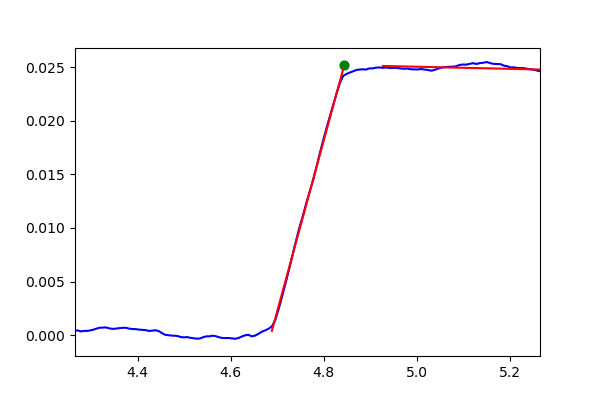

In [116]:
# Ideallly the transition should result in the largest peak in the derivative signal
drop_pos = result['locations'][0]

# Fit the curve to a Gaussian to estimate the width of the peak and therefore the size of the window
# in which the drop occurs
gauss_fit, pcov = optimize.curve_fit(multiple_gaussian, t, drdt, [0, drop_pos, 1, .5])
stdev = abs(gauss_fit[3])

# Estimate the window over which the drop occurs
drop_window = np.nonzero(np.logical_and(t >= drop_pos - stdev, t <= drop_pos + stdev))
drop_t = t[drop_window]
drop_rv = rv[drop_window]

# Fit the drop section to a linear curve
drop_fit = stats.linregress(drop_t, drop_rv)

# Pick the a section of the plateau before the drop
plateau_window = np.nonzero(np.logical_and(t >= drop_pos + 2*stdev, t <= drop_pos + 2*stdev + 0.5))
plateau_t = t[plateau_window]
plateau_rv = rv[plateau_window]
plateau_fit = stats.linregress(plateau_t, plateau_rv)

# Print out the estimated Tc
estimated_tc = (drop_fit.intercept - plateau_fit.intercept) / (plateau_fit.slope - drop_fit.slope)
print('Tc = {0}'.format(estimated_tc))

# Setup the plot
fig, ax = plt.subplots(figsize = (6, 4))

# Plot the data with the fitted lines
ax.plot(t, rv, color = 'blue')
#ax.plot(t,drdt, color = 'blue')
ax.plot(drop_t, drop_fit.slope * drop_t + drop_fit.intercept, color = 'red')
ax.plot(plateau_t, plateau_fit.slope * plateau_t + plateau_fit.intercept, color = 'red')
ax.scatter(estimated_tc, drop_fit.intercept + drop_fit.slope*estimated_tc, s = 40, c = 'green')
ax.set_xlim((drop_pos - .5, drop_pos + .5))

# Display plot and save
fplt.show()